In [1]:
import sys
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis")
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis\read")

import numpy as np
import math
import pandas as pd
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import data_analysis_utils as utils
import calibrate_power as cbp
from read_scope_data import read_trc_data

%matplotlib widget

In [15]:
def read_excel_sheets(filepath):
    """
    Read an Excel file and extract columns with non-zero values from each sheet.

    Parameters:
    filepath (str): The path to the Excel file.

    Returns:
    dict: A dictionary containing the sheet names as keys and the columns with non-zero values as values.
    """
    data_dict = {}

    # Read the Excel file
    xls = pd.ExcelFile(filepath)
    print(xls.sheet_names)

    # Iterate over each sheet in the Excel file
    for sheet_name in xls.sheet_names:
        # Read the sheet into a DataFrame
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        col_list = df.columns.tolist()
        # # Get the selected columns as a NumPy array
        selected_columns = df[['time, s - Plot 0', '1/c.tau, 1/cm - Plot 0']].values

        # Add the selected columns to the data dictionary
        data_dict[sheet_name] = selected_columns

    xls.close()

    return data_dict

ifn = r"C:\data\epfl\diagnostic source\CRDS\solenoid\20230601_15mTorr_0.15lnmin.xlsx"
dic_15mT = read_excel_sheets(ifn)

['330W-20W', '400W-20W', '510W-10W', '590W-10W']


plot
Reading data...
Done


NameError: name 'Vtrig' is not defined

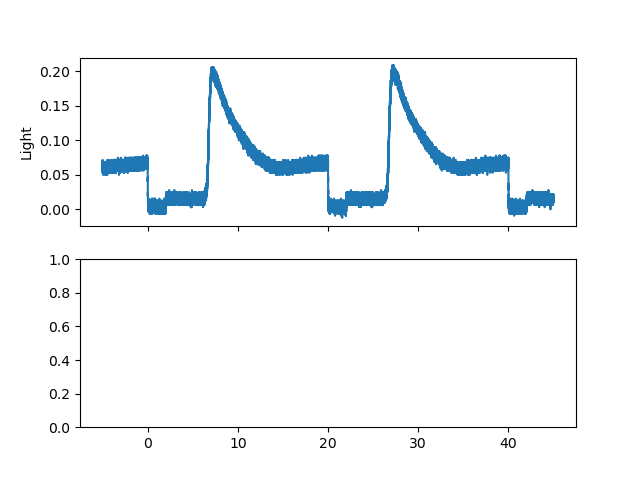

In [2]:
path = r"C:\data\epfl\diagnostic-source\CRDS\scope-trc\solAnt"
file_ls = utils.get_files_in_folder(path)
for file in file_ls:
    if "15mT" in file:
        power = utils.get_number_before_keyword(file, "W")
        if power == 300:
            print("plot")
            if "C3" in file:
                light, tarr = read_trc_data(file)
            if "C4" in file:
                Vtrig, tarr = read_trc_data(file)
                
            fig, ax = plt.subplots(nrows=2, sharex=True)

            ax[0].plot(tarr*1e3, light)
            ax[0].set_ylabel('Light')

            ax[1].plot(tarr*1e3, Vtrig)
            ax[1].set_ylabel('TTL')
            ax[1].set_xlabel('time (ms)')

In [18]:
def get_real_power(path, pressure):

    file_ls = utils.get_files_in_folder(path)
    for file in file_ls:
        if f"{pressure}mT" in file:
            
    
    ifn_light = path + f"C3-{power}W-{pressure}mT-00000.trc"
    light, tarr = read_trc_data(ifn_light)

    ifn_Vtrig = path + f"C4-{power}W-{pressure}mT-00000.trc"
    Vtrig, tarr = read_trc_data(ifn_Vtrig)

    fig, ax = plt.subplots(nrows=2, sharex=True)

    ax[0].plot(tarr*1e3, light)
    ax[0].set_ylabel('Light')

    ax[1].plot(tarr*1e3, Vtrig)
    ax[1].set_ylabel('TTL')
    ax[1].set_xlabel('time (ms)')

    start = 20000
    stop = 24000
    ax[0].plot(tarr[start:stop]*1e3, light[start:stop]) # plot range to take average
    lavg = np.average(light[start:stop]) * 1e3 # take average light signal conver V to mV
    pwr = cbp.ltop_solenoid(lavg, pressure) # Calibrated power according to CW light signal
    print(f'Power = {pwr} W')

    return pwr


pressure = 15
power = 300
real_power = get_real_power(path, pressure, 0.15)

In [ ]:
fig = plt.figure()
plt.scatter(tarr_crds, sig_crds)

# signal baseline
start = 200
stop = 240
plt.scatter(tarr_crds[start:stop], sig_crds[start:stop])
sig_base = np.average(sig_crds[start:stop])

# signal active-glow equilibrium value
start = -70
stop = -20
plt.scatter(tarr_crds[start:stop], sig_crds[start:stop])
sig_val = np.average(sig_crds[start:stop])

print('%.2e' %(sig_val-sig_base))

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True)
fig.suptitle('5mTorr/0.67Pa 580W')

ax[0].plot(tarr*1e3, light)
ax[0].set_ylabel('Light')

ax[1].plot(tarr*1e3, Vtrig)
ax[1].set_ylabel('TTL')

tarr_fake = tarr_crds + tarr_crds[-1]
tarr_crds_mod = np.hstack((tarr_crds, tarr_fake)) #+tarr_crds[100]
sig_crds_mod = np.tile(sig_crds , 2) #numpy.roll(sig_crds,-100)

ax[2].plot(tarr_crds_mod*1e3, sig_crds_mod)
ax[2].set_ylabel('crds signal')
ax[2].set_xlabel('time (ms)')